In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_iterative_imputer  # IterativeImputer 활성화
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.calibration import calibration_curve

# 데이터 로드
train_path = "/content/train.csv"  # Google Colab 환경에 맞게 수정
test_path = "/content/test.csv"
df_train = pd.read_csv(train_path).drop(columns=['ID'], errors='ignore')
df_test = pd.read_csv(test_path).drop(columns=['ID'], errors='ignore')

In [ ]:
# 결측값 처리 - y_train의 NaN 제거
df_train = df_train.dropna(subset=['임신 성공 여부'])

In [ ]:
# 독립 변수(X)와 종속 변수(y) 분리
X_train = df_train.drop(columns=['임신 성공 여부'], errors='ignore')
y_train = df_train['임신 성공 여부'].fillna(df_train['임신 성공 여부'].mode()[0])  # 최빈값으로 결측값 채움
X_test = df_test.copy()

In [ ]:
# 상위 20개 중요한 변수만 선택
important_features = [
    "시술 시기 코드", "총 생성 배아 수", "수집된 신선 난자 수", "시술 당시 나이", "배아 이식 경과일",
    "이식된 배아 수", "총 시술 횟수", "해동된 배아 수", "총 임신 횟수", "배아 생성 주요 이유",
    "미세주입된 난자 수", "IVF 임신 횟수", "난자 채취 경과일", "배란 유도 유형", "정자 출처",
    "총 출산 횟수", "DI 임신 횟수", "IVF 시술 횟수", "남성 주 불임 원인", "불임 원인 - 배란 장애"
]
X_train = X_train[important_features]
X_test = X_test[important_features]

In [ ]:
# 범주형 변수 인코딩
categorical_columns = [col for col in important_features if X_train[col].dtype == 'object']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[categorical_columns] = ordinal_encoder.fit_transform(X_train[categorical_columns])
X_test[categorical_columns] = ordinal_encoder.transform(X_test[categorical_columns])

In [ ]:
# 결측값 처리 - Iterative Imputer 사용
iterative_imputer = IterativeImputer(random_state=42)
X_train = pd.DataFrame(iterative_imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(iterative_imputer.transform(X_test), columns=X_test.columns)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# DecisionTreeClassifier 모델 학습
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [ ]:
# 예측 및 평가
y_pred = dt_model.predict(X_train)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

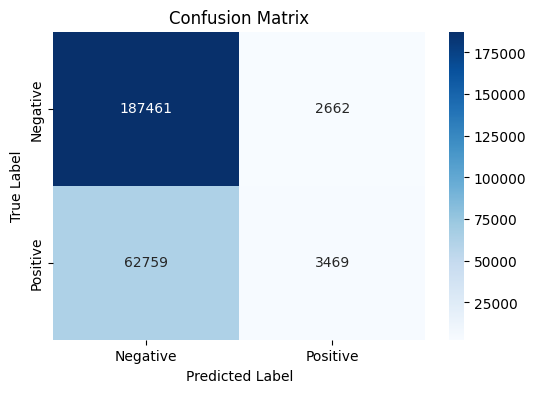

In [ ]:
# Confusion Matrix 시각화
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<ipython-input-11-20c3b2502822>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48176 (\N{HANGU

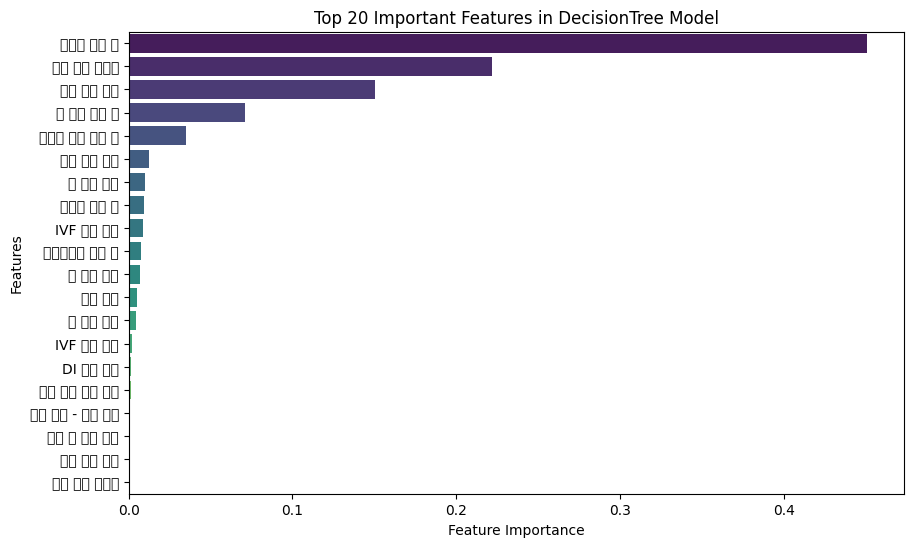

In [ ]:
# Feature Importance 시각화
importances = pd.DataFrame({'Feature': important_features, 'Importance': dt_model.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Important Features in DecisionTree Model')
plt.show()

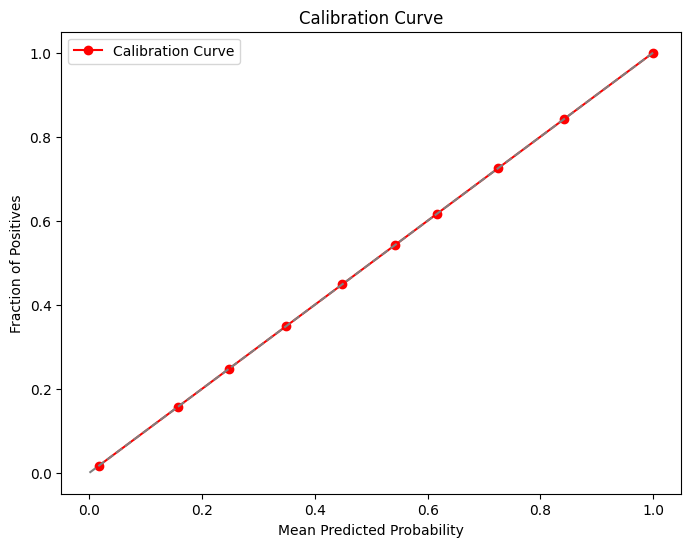

In [ ]:
# Calibration Curve 시각화
prob_true, prob_pred = calibration_curve(y_train, dt_model.predict_proba(X_train)[:, 1], n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='red', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfectly calibrated line
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [ ]:
# # ROC Curve 시각화
# plt.figure(figsize=(8, 6))
# fpr, tpr, _ = roc_curve(y_train, rf_model.predict_proba(X_train)[:, 1])
# plt.plot(fpr, tpr, color='blue', label='Training ROC Curve')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.show()

NameError: name 'rf_model' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission['probability'] = y_pred_proba

In [ ]:
sample_submission.to_csv('./baseline_submit5.csv', index=False)